# LACA3 - Experiment1: PGD OoD Testset

<br/>

<pre>
model name:            imagenette_128_resnet18_model.pth
network architecture:  resnet18
image size:            128x128
test set:              PGD testset (adversarial OoD testset)
threshold:             0.05
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagenette dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagenette dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

We test our OoD method on the official test set of the [Imagenette dataset](https://github.com/fastai/imagenette) to see how the method performs on in-distribution samples.

<br/>

_Sources:_
* [Imagenette dataset](https://github.com/fastai/imagenette)
* [Fetching activations in PyTorch](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html)
* [Deep kNN paper](https://arxiv.org/abs/1803.04765)
* [Deep kNN sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py)
* [Deep kNN sample code (PyTorch)](https://github.com/bam098/deep_knn/blob/master/dknn_mnist.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
from pathlib import Path
import random
import warnings
import pprint
from collections import Counter
import time
import math

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagenette')       # Base data folder
fname_string      = 'imagenette_{}_resnet18_model_adv_pgd'.format(img_size)         # Adversarial file name
adv_path          = base_data_folder/fname_string                                   # Adversarial file path

# Model
fname_string      = 'imagenette_{}'.format(img_size)                                # Dataset folder name
base_model_folder = Path('/Users/lehmann/research/laca3/models/imagenette')         # Base model folder
mfname_string     = fname_string + '_resnet18_model'                                # Model name
model_path        = base_model_folder/mfname_string                                 # Model path
arch              = models.resnet18(pretrained=False)                               # Network architecture

# Activations
# CAUTION --> make sure you chose the correct layers below!

# Projections
base_projs_folder = Path('/Users/lehmann/research/laca3/projections/imagenette')    # Base projection folder
pfname_string     = 'imagenette_{}_resnet18_projs'.format(img_size)                 # Projections file name
projs_path        = base_projs_folder/pfname_string                                 # Projections path

# Clusters and Stats
base_cstats_folder = Path('/Users/lehmann/research/laca3/cluster_stats/imagenette') # Base projection folder
cfname_string     = 'imagenette_{}_resnet18_cstats'.format(img_size)                # Projections file name
cstats_path        = base_cstats_folder/cfname_string                               # Activations path

# LACA3
t                 = 0.05                                                            # Threshold for credib calc

## Function for Displaying Images

In [4]:
labels = (
    'tench', 
    'English springer', 
    'cassette player', 
    'chain saw', 
    'church', 
    'French horn', 
    'garbage truck', 
    'gas pump', 
    'golf ball', 
    'parachute'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
        img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
        img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [5]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples. When we split the dataset we use the seed value for [reproducibility](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [7]:
# Create test dataloader
testloader = torch.load(str(adv_path)+'.pth')

# Check size of test set
test_size = len(testloader.dataset)
print('testset size:  {}'.format(test_size))

testset size:  3175


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


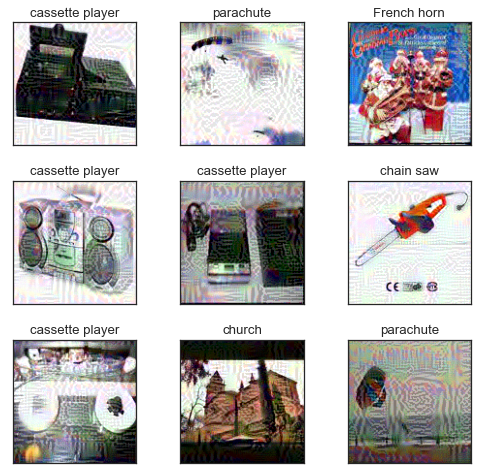

In [8]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [9]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Test Functions

In [11]:
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Testing

In [12]:
# Create Model
model = arch
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load(str(model_path)+'.pth', map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [13]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [14]:
test_acc = test_final(model, testloader, criterion)
print('test accuracy:  {}'.format(test_acc))


Test set: Avg. loss: 0.024887, Accuracy: 173/3175 (5.45%)

test accuracy:  5.448818897637795


## Set Layers

__Make sure to choose the correct layers here!__

In [15]:
layers = {                                     
    'relu': model.relu,
    'maxpool': model.maxpool,
    'layer1-0': model.layer1[0],
    'layer1-1': model.layer1[1],
    'layer2-0': model.layer2[0],
    'layer2-1': model.layer2[1],
    'layer3-0': model.layer3[0],
    'layer3-1': model.layer3[1],
    'layer4-0': model.layer4[0],
    'layer4-1': model.layer4[1],
    'avgpool': model.avgpool
}

## Define Function for Plotting Projections and Clusters

In [16]:
def plot_projects(projections, cluster_labels=None, cluster_centers=None):
    layers = list(projections['projections'].keys())
    
    for layer_name in layers:        
        df = pd.DataFrame()
        df['x'] = projections['projections'][layer_name][:,0]
        df['y'] = projections['projections'][layer_name][:,1]
        
        if cluster_labels is not None:
            df['targets'] = cluster_labels[layer_name]
        else:
            df['targets'] = projections['targets']
    
        plot = sns.lmplot(
            x='x', y='y', data=df, fit_reg=False, hue='targets', height=8, palette='muted', legend=False,
            scatter_kws={'marker': 'D', 's': 50, 'alpha': 0.6}
        ).set_axis_labels('x1','x2')
    
        if cluster_labels is not None:
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers[layer_name]), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)
    
        fig = plot.fig
        fig.suptitle('Projections from Layer {}'.format(layer_name), y=1.025, fontsize = 20)

## Load Trainset Projections

In [17]:
loaded_train_projections = {}

fname = str(projs_path) + '_{}_all.pkl'.format('trainset')
with open(fname, 'rb') as pickle_file:
    loaded_train_projections = pickle.load(pickle_file)

In [18]:
print('targets: {}'.format(loaded_train_projections['targets'].shape))
print()

for layer_name in layers:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(loaded_train_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(loaded_train_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(loaded_train_projections['reducer'][layer_name]))
    print()

targets: (9469,)

## layer relu
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (9469, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric

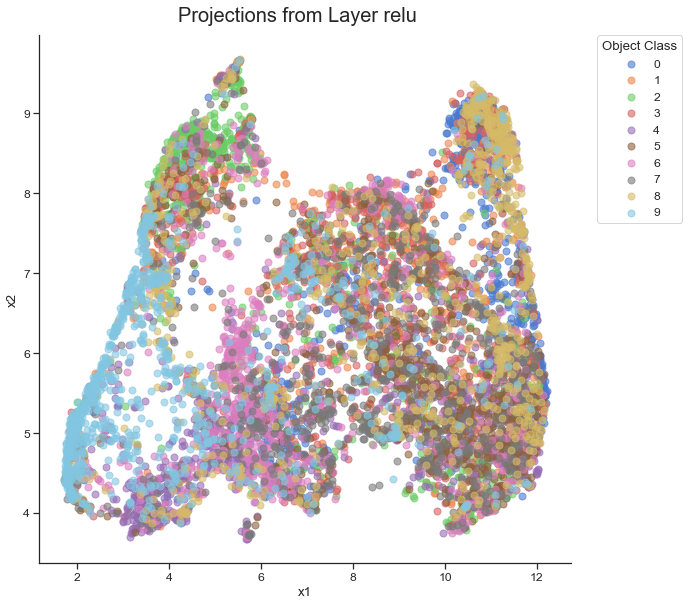

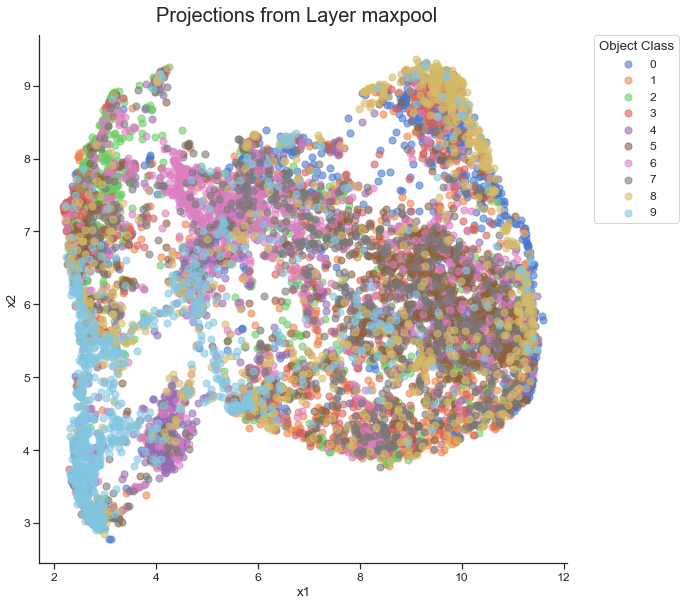

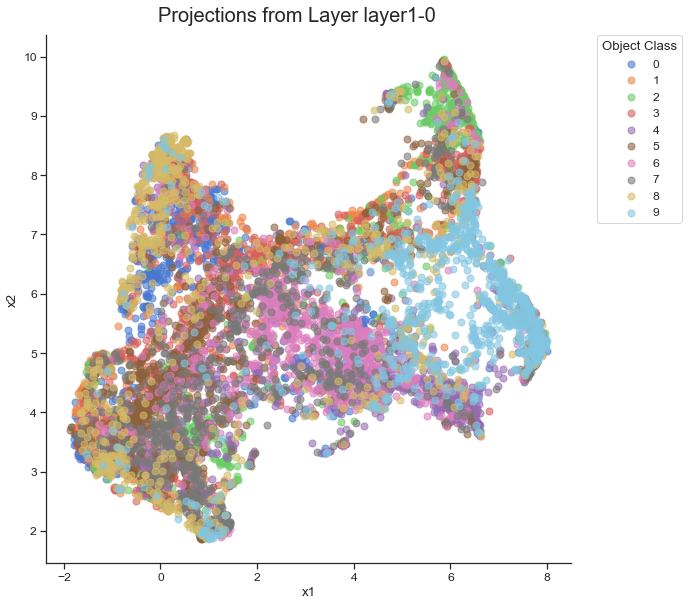

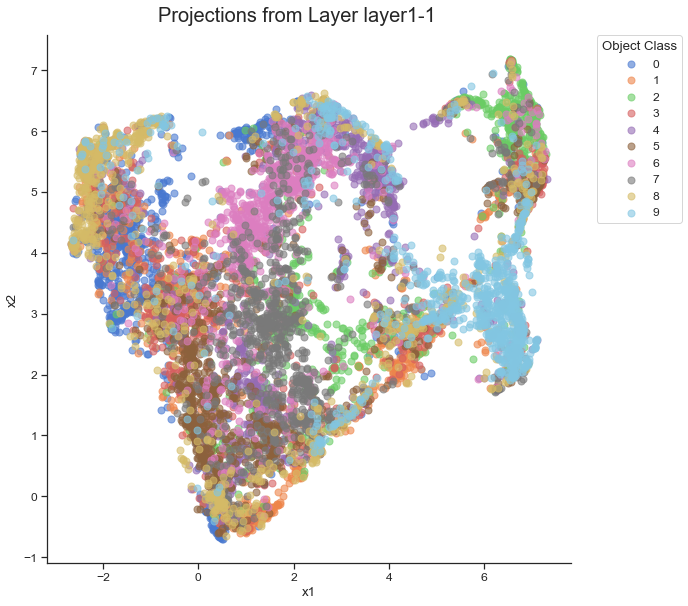

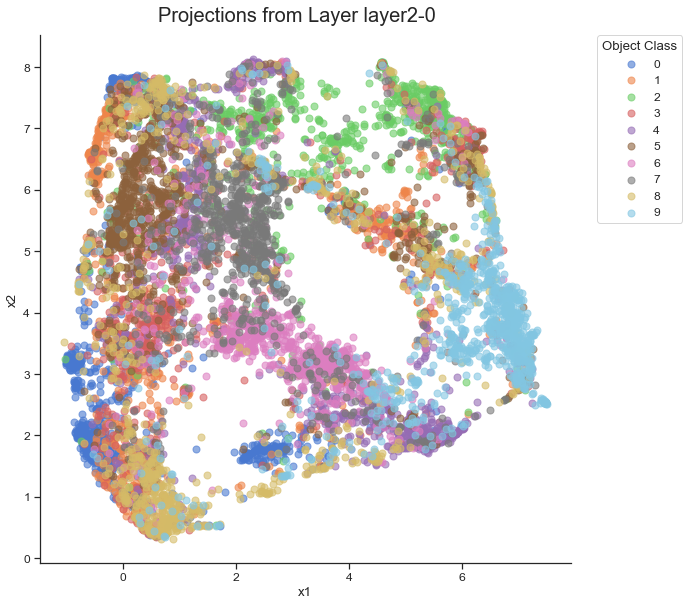

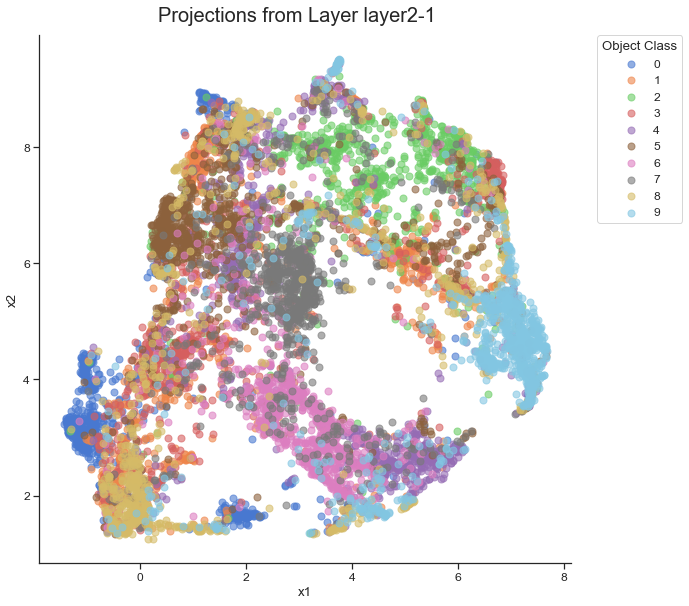

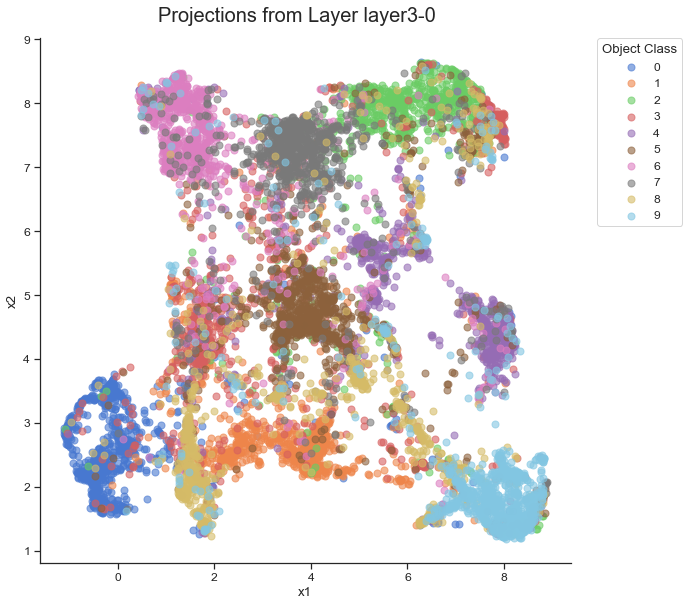

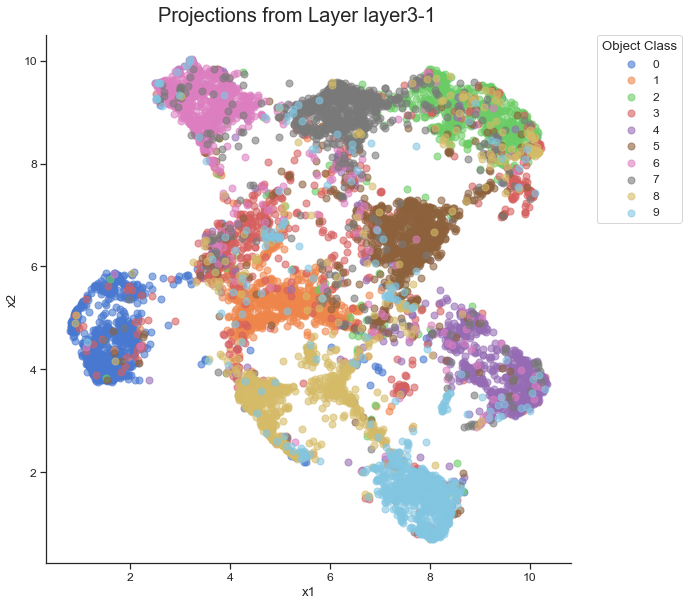

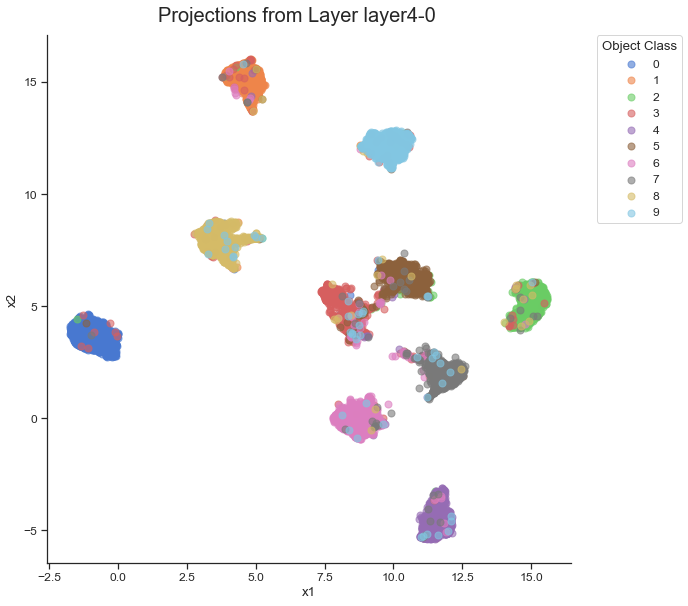

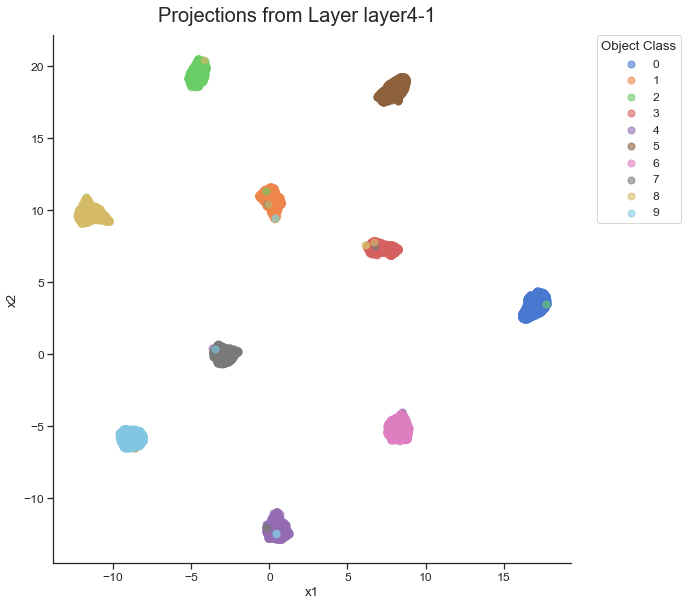

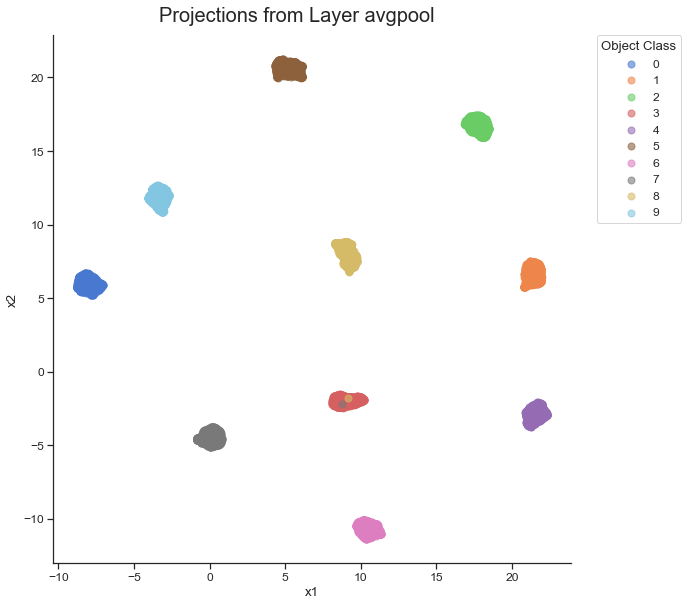

In [19]:
plot_projects(loaded_train_projections)

## Load Cluster Models and Stats

In [20]:
fname = str(cstats_path)+'.pkl'
with open(fname, 'rb') as pickle_file:
    loaded_clusters_and_stats = pickle.load(pickle_file)

In [21]:
for layer_name in layers:
    print('## layer {}'.format(layer_name))
    print('cluster labels:  {}'.format(loaded_clusters_and_stats['train_clusters']['cluster_labels'][layer_name].shape))
    print('cluster centers: {}'.format(loaded_clusters_and_stats['train_clusters']['cluster_centers'][layer_name].shape))
    print('clusterer:       {}'.format(loaded_clusters_and_stats['train_clusters']['clusterer'][layer_name]))
    print()

## layer relu
cluster labels:  (9469,)
cluster centers: (6, 2)
clusterer:       KMeans(n_clusters=6)

## layer maxpool
cluster labels:  (9469,)
cluster centers: (6, 2)
clusterer:       KMeans(n_clusters=6)

## layer layer1-0
cluster labels:  (9469,)
cluster centers: (5, 2)
clusterer:       KMeans(n_clusters=5)

## layer layer1-1
cluster labels:  (9469,)
cluster centers: (5, 2)
clusterer:       KMeans(n_clusters=5)

## layer layer2-0
cluster labels:  (9469,)
cluster centers: (5, 2)
clusterer:       KMeans(n_clusters=5)

## layer layer2-1
cluster labels:  (9469,)
cluster centers: (13, 2)
clusterer:       KMeans(n_clusters=13)

## layer layer3-0
cluster labels:  (9469,)
cluster centers: (14, 2)
clusterer:       KMeans(n_clusters=14)

## layer layer3-1
cluster labels:  (9469,)
cluster centers: (10, 2)
clusterer:       KMeans(n_clusters=10)

## layer layer4-0
cluster labels:  (9469,)
cluster centers: (10, 2)
clusterer:       KMeans(n_clusters=10)

## layer layer4-1
cluster labels:  (9469,)


In [22]:
pprint.pprint(loaded_clusters_and_stats['train_clusters']['stats'])

{'avgpool': {0: {7: 1.0},
             1: {2: 1.0},
             2: {9: 1.0},
             3: {4: 1.0},
             4: {8: 1.0},
             5: {6: 1.0},
             6: {5: 1.0},
             7: {1: 1.0},
             8: {3: 0.9976744186046511,
                 7: 0.0011627906976744186,
                 8: 0.0011627906976744186},
             9: {0: 1.0}},
 'layer1-0': {0: {0: 0.021844660194174758,
                  1: 0.021035598705501618,
                  2: 0.021035598705501618,
                  3: 0.013754045307443365,
                  4: 0.26779935275080907,
                  5: 0.0186084142394822,
                  6: 0.05906148867313916,
                  7: 0.04692556634304207,
                  8: 0.06796116504854369,
                  9: 0.46197411003236244},
              1: {0: 0.06442477876106195,
                  1: 0.12530973451327435,
                  2: 0.1136283185840708,
                  3: 0.08424778761061946,
                  4: 0.10407079646017699,
     

              5: 0.12894736842105264,
              6: 0.07789473684210527,
              7: 0.14526315789473684,
              8: 0.07421052631578948,
              9: 0.053157894736842105}}}


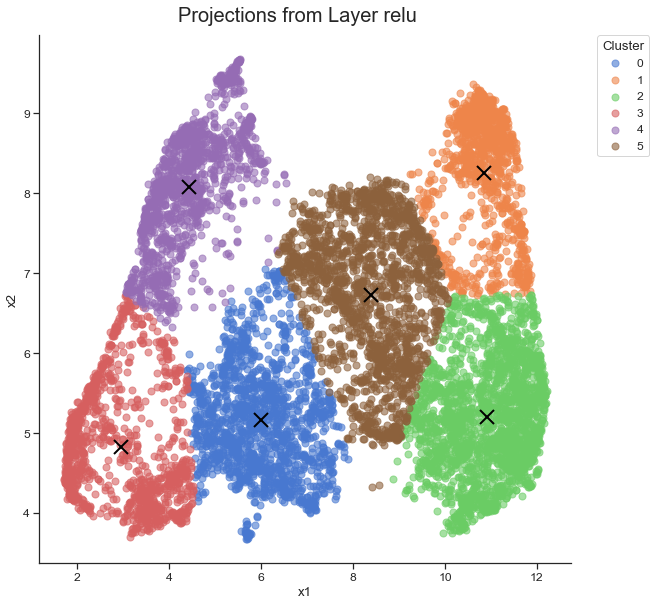

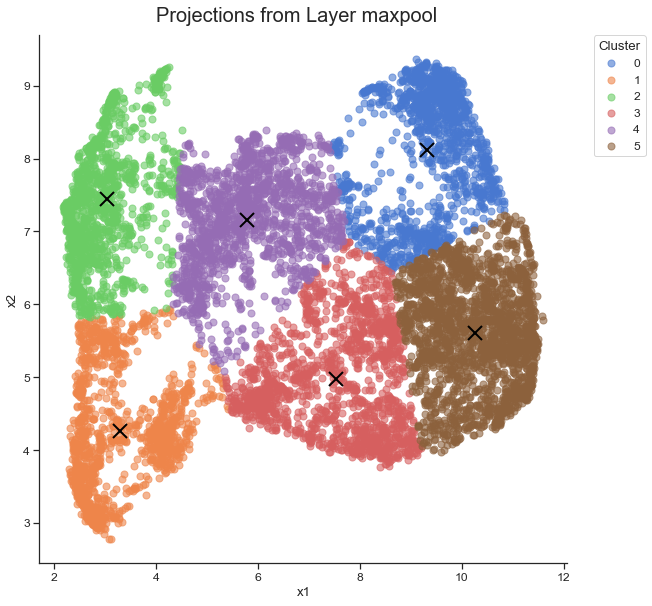

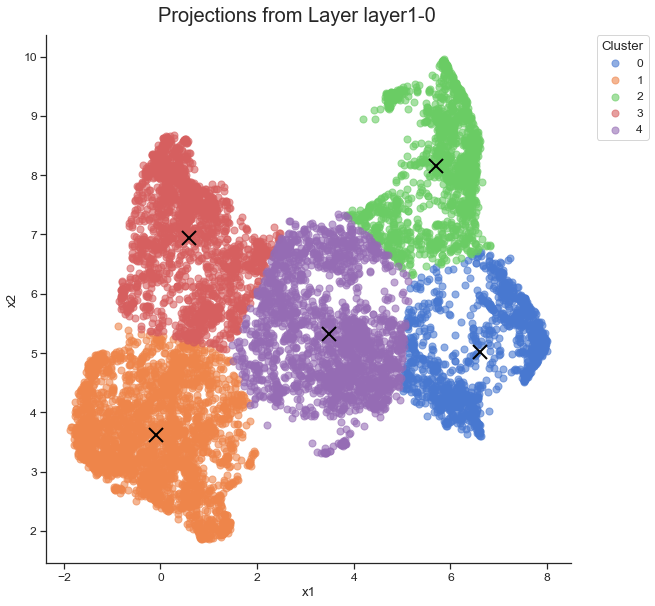

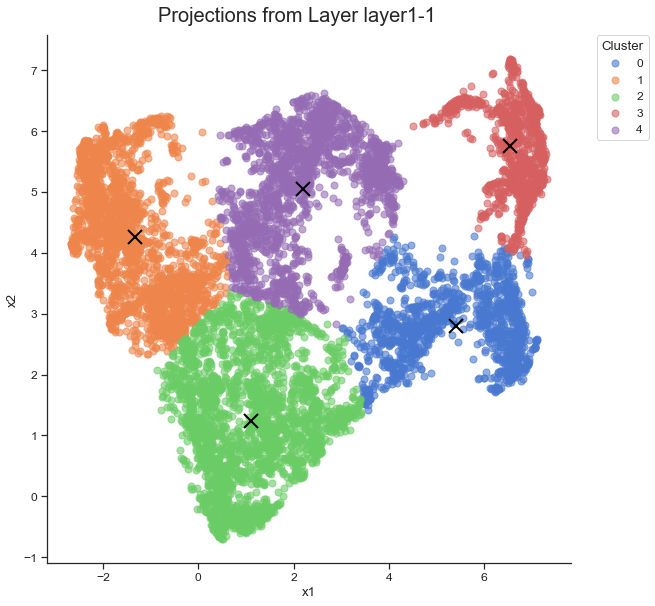

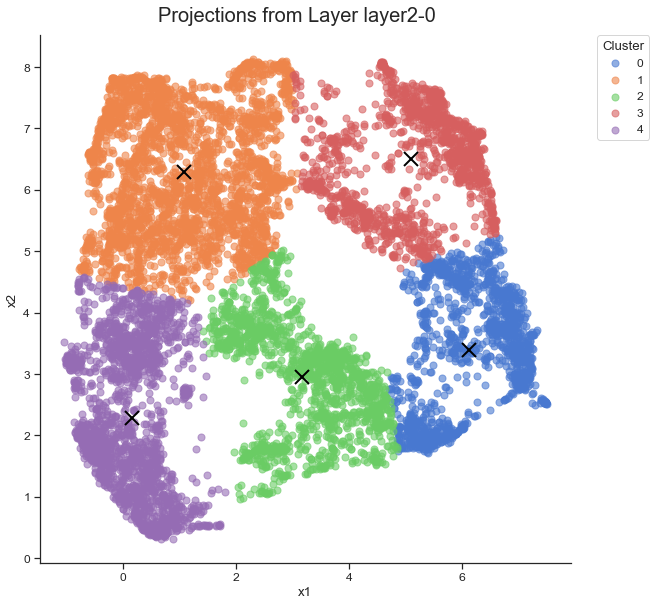

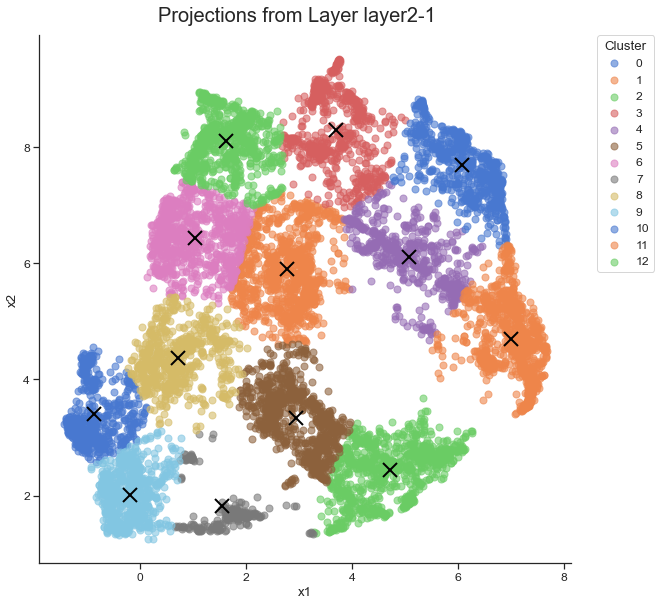

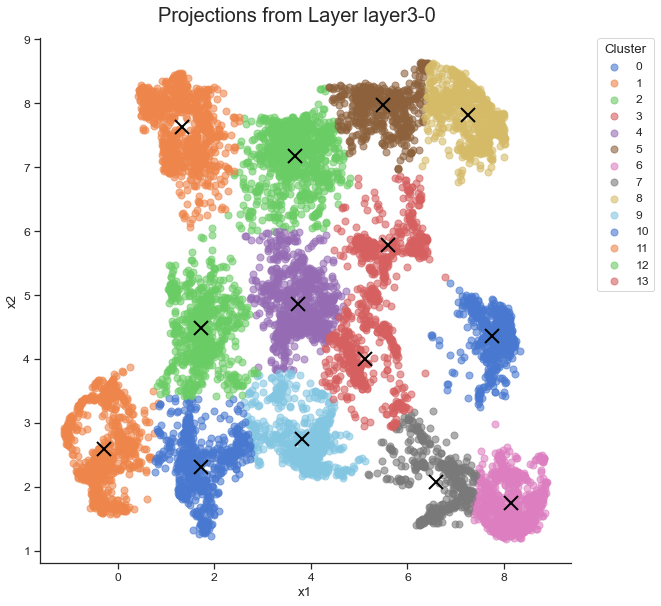

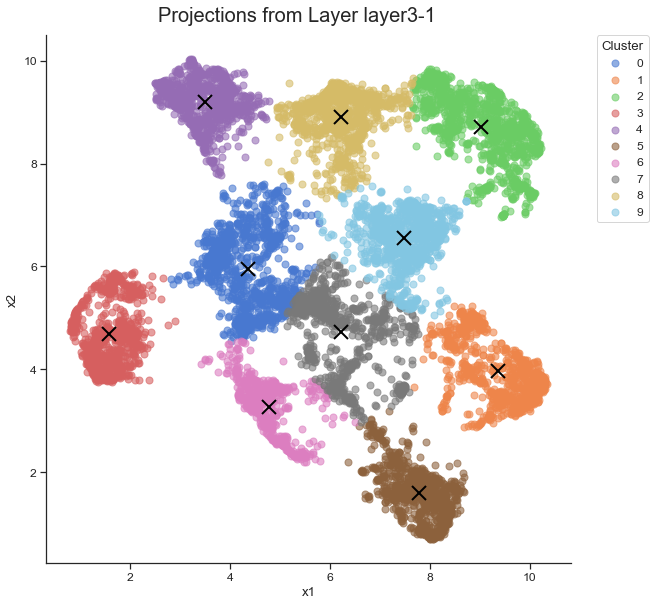

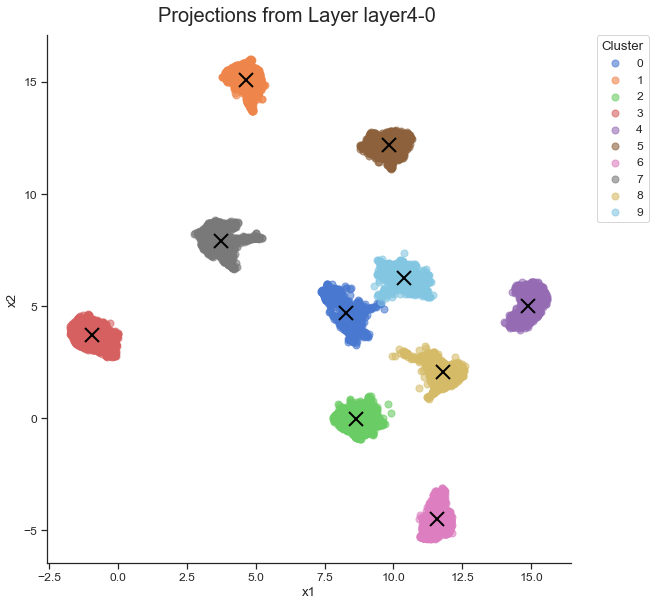

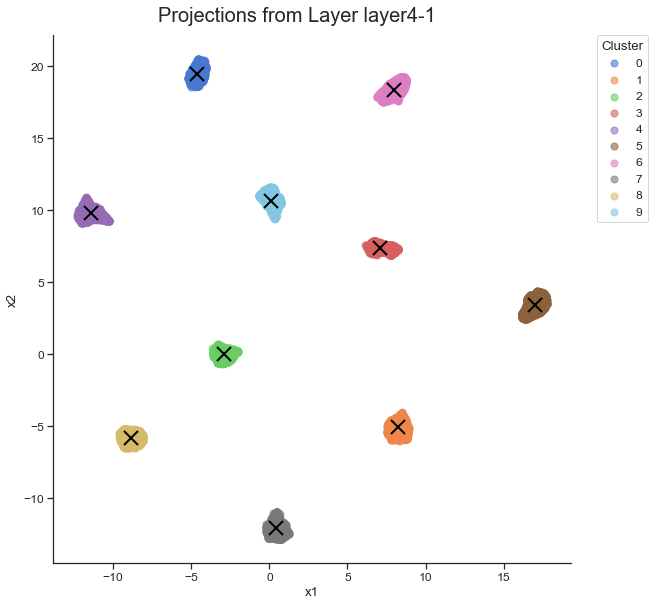

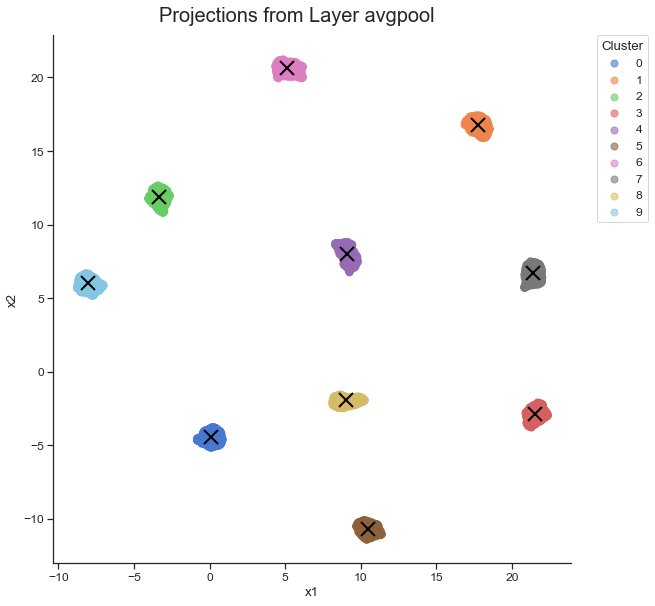

In [23]:
plot_projects(
    loaded_train_projections, 
    loaded_clusters_and_stats['train_clusters']['cluster_labels'], 
    loaded_clusters_and_stats['train_clusters']['cluster_centers']
)

In [24]:
pprint.pprint(loaded_clusters_and_stats['layer_weights']); print()
print(f"sum = {sum(loaded_clusters_and_stats['layer_weights'].values())}")

{'avgpool': 0.19,
 'layer1-0': 0.03,
 'layer1-1': 0.03,
 'layer2-0': 0.04,
 'layer2-1': 0.07,
 'layer3-0': 0.1,
 'layer3-1': 0.12,
 'layer4-0': 0.18,
 'layer4-1': 0.19,
 'maxpool': 0.03,
 'relu': 0.02}

sum = 1.0


In [25]:
pprint.pprint(loaded_clusters_and_stats['calib_stats'])

{0.01: {'avgpool': {0: {9: 1.0},
                    1: {7: 1.0},
                    2: {1: 1.0},
                    3: {8: 1.0},
                    4: {3: 1.0},
                    5: {6: 1.0},
                    6: {5: 1.0},
                    7: {0: 1.0},
                    8: {4: 1.0},
                    9: {2: 1.0}},
        'layer1-0': {0: {0: 0.021052631578947368,
                         1: 0.18947368421052632,
                         2: 0.010526315789473684,
                         3: 0.5473684210526316,
                         4: 0.23157894736842105},
                     1: {0: 0.05555555555555555,
                         1: 0.4305555555555556,
                         2: 0.25,
                         3: 0.20833333333333334,
                         4: 0.05555555555555555},
                     2: {0: 0.019230769230769232,
                         1: 0.40384615384615385,
                         2: 0.5384615384615384,
                         4: 0.038461538461538

                     4: {7: 1.0},
                     5: {6: 1.0},
                     6: {1: 1.0},
                     7: {2: 1.0},
                     8: {4: 1.0},
                     9: {8: 1.0}},
        'maxpool': {0: {0: 0.38461538461538464,
                        3: 0.054945054945054944,
                        4: 0.3076923076923077,
                        5: 0.25274725274725274},
                    1: {0: 0.19047619047619047,
                        2: 0.1111111111111111,
                        3: 0.4126984126984127,
                        5: 0.2857142857142857},
                    2: {2: 0.5555555555555556,
                        3: 0.15555555555555556,
                        5: 0.28888888888888886},
                    3: {0: 0.22058823529411764,
                        2: 0.19117647058823528,
                        3: 0.29411764705882354,
                        4: 0.07352941176470588,
                        5: 0.22058823529411764},
                    4: {1: 

## Get Testset Credibility

### Fetch Activations

In [26]:
def fetch_activations(dataloader, model, layers): 
    activations = {}
    activations['activations'] = {}
    activations['targets'] = []
    
    handlers = {}
    
    # Define hook
    def get_activations(layer_name):
        def hook(model, input, output):
            activations['activations'][layer_name].append(output.squeeze().detach().cpu().numpy())
        return hook
    
    # Register Hooks
    print('## Registering Hooks')
    
    for layer_name in layers:
        print('Register Hook for Layer {}'.format(layer_name))
        activations['activations'][layer_name] = []
        handlers[layer_name] = layers[layer_name].register_forward_hook(get_activations(layer_name))
    
    print()
        
    # Fetch activations
    print('## Fetching Activations')
    targets = []
    
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()
            
        _ = model(batch[0])

        if len(batch) > 1:
            activations['targets'].append(batch[1].detach().cpu().numpy())
            
    print('- activations fetched')
    print()
     
    # Concetenate batch activations/targets and remove hooks
    print('## Removing Hooks')
    activations['targets'] = np.concatenate(activations['targets'])
    
    for layer_name in layers:
        print('Remove Hook from Layer {}'.format(layer_name))
        activations['activations'][layer_name] = np.concatenate(activations['activations'][layer_name])
        handlers[layer_name].remove()
        
    print()
    print("done!")        
    print()
        
    return activations

In [27]:
start_fetch_act = time.time()

activations_test = fetch_activations(testloader, model, layers)

end_fetch_act = time.time()

## Registering Hooks
Register Hook for Layer relu
Register Hook for Layer maxpool
Register Hook for Layer layer1-0
Register Hook for Layer layer1-1
Register Hook for Layer layer2-0
Register Hook for Layer layer2-1
Register Hook for Layer layer3-0
Register Hook for Layer layer3-1
Register Hook for Layer layer4-0
Register Hook for Layer layer4-1
Register Hook for Layer avgpool

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
- activations fetched

## Removing Hooks
Remove Hook from Layer relu
Remove Hook from Layer maxpool
Remove Hook from Layer layer1-0
Remove Hook from Layer layer1-1
Remove Hook from Layer layer2-0
Remove Hook from Layer layer2-1
Remove Hook from Layer layer3-0
Remove Hook from Layer layer3-1
Remove Hook from Layer layer4-0
Remove Hook from Layer layer4-1
Remove Hook from Layer avgpool

done!



In [28]:
print('targets: {}'.format(activations_test['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activations_test['activations'][layer].shape))
    print()

targets: (3175,)

## layer relu
activations: (3175, 64, 64, 64)

## layer maxpool
activations: (3175, 64, 32, 32)

## layer layer1-0
activations: (3175, 64, 32, 32)

## layer layer1-1
activations: (3175, 64, 32, 32)

## layer layer2-0
activations: (3175, 128, 16, 16)

## layer layer2-1
activations: (3175, 128, 16, 16)

## layer layer3-0
activations: (3175, 256, 8, 8)

## layer layer3-1
activations: (3175, 256, 8, 8)

## layer layer4-0
activations: (3175, 512, 4, 4)

## layer layer4-1
activations: (3175, 512, 4, 4)

## layer avgpool
activations: (3175, 512)



### Transform Activations to Vectors

In [29]:
def transform_acts2vec(activations, pool=None):
    activation_vectors = {}
    activation_vectors['activations'] = {}
    activation_vectors['targets'] = None
    
    layers = list(activations['activations'].keys())
    
    for layer_name in layers:
        print('## Transforming Activations to Vector Form for Layer {}'.format(layer_name))
        
        # Transform activations
        layer_activations = activations['activations'][layer_name]
        layer_activation_vectors = []
        
        for i in range(layer_activations.shape[0]):
            sample_activation_vector = transform_acts2vec_from_sample(layer_activations[i], pool)            
            layer_activation_vectors.append(sample_activation_vector)
                        
        layer_activation_vectors = np.array(layer_activation_vectors)    
        print('- activations transformed: {}'.format(layer_activation_vectors.shape))
        
        # Save activations vectors
        activation_vectors['activations'][layer_name] = layer_activation_vectors
        
        # Copy targets
        activation_vectors['targets'] = activations['targets']

        print("done!")        
        print()
    
    return activation_vectors


def transform_acts2vec_from_sample(sample_activations, pool=(2,2)):
    if len(sample_activations.shape) == 3:
        if pool is None:
            sample_activations = sample_activations.flatten()
        else:
            sample_activations = np.array([
                block_reduce(act_map, pool, np.mean) for act_map in sample_activations
            ]).flatten()
                        
    return sample_activations

In [30]:
start_transf = time.time()

activation_vectors_test = transform_acts2vec(activations_test, None)

end_transf = time.time()

## Transforming Activations to Vector Form for Layer relu
- activations transformed: (3175, 262144)
done!

## Transforming Activations to Vector Form for Layer maxpool
- activations transformed: (3175, 65536)
done!

## Transforming Activations to Vector Form for Layer layer1-0
- activations transformed: (3175, 65536)
done!

## Transforming Activations to Vector Form for Layer layer1-1
- activations transformed: (3175, 65536)
done!

## Transforming Activations to Vector Form for Layer layer2-0
- activations transformed: (3175, 32768)
done!

## Transforming Activations to Vector Form for Layer layer2-1
- activations transformed: (3175, 32768)
done!

## Transforming Activations to Vector Form for Layer layer3-0
- activations transformed: (3175, 16384)
done!

## Transforming Activations to Vector Form for Layer layer3-1
- activations transformed: (3175, 16384)
done!

## Transforming Activations to Vector Form for Layer layer4-0
- activations transformed: (3175, 8192)
done!

## Transforming

In [31]:
print('targets: {}'.format(activation_vectors_test['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activation_vectors_test['activations'][layer].shape))
    print()

targets: (3175,)

## layer relu
activations: (3175, 262144)

## layer maxpool
activations: (3175, 65536)

## layer layer1-0
activations: (3175, 65536)

## layer layer1-1
activations: (3175, 65536)

## layer layer2-0
activations: (3175, 32768)

## layer layer2-1
activations: (3175, 32768)

## layer layer3-0
activations: (3175, 16384)

## layer layer3-1
activations: (3175, 16384)

## layer layer4-0
activations: (3175, 8192)

## layer layer4-1
activations: (3175, 8192)

## layer avgpool
activations: (3175, 512)



### Get Projections

In [32]:
def get_projections(activation_vectors, ext_scaler, ext_reducer):    
    projections = {}
    projections['projections'] = {}
    projections['targets'] = None
    projections['scaler'] = {}
    projections['reducer'] = {}
    
    for layer_name in layers:
        print('## Computing Projections for Layer {}'.format(layer_name))
        
        # Normalize activations
        print('- external scaler is used')
        layer_activations = activation_vectors['activations'][layer_name]
        layer_activations_norm = ext_scaler[layer_name].transform(layer_activations)
        
        print('- activations normalized: {}'.format(layer_activations_norm.shape))
        
        # Reduce activations
        print('- external reducer is used')
        proj_temp = layer_activations_norm
        for r in ext_reducer[layer_name]:
            proj_temp = r.transform(proj_temp)
        layer_projections = proj_temp
            
        print('- activations reduced: {}'.format(layer_projections.shape))
        
        # Save projections and reducer
        projections['projections'][layer_name] = layer_projections
        projections['reducer'][layer_name] = ext_reducer[layer_name]
        projections['scaler'][layer_name] = ext_scaler[layer_name]

        # Copy targets
        if activation_vectors['targets'] is not None:
            if projections['targets'] is not None:
                np.testing.assert_array_equal(projections['targets'], activation_vectors['targets'])
            else:
                projections['targets'] = activation_vectors['targets']

        print("done!")        
        print()

    return projections

In [33]:
start_proj = time.time()

projections_test = get_projections(
    activation_vectors_test, 
    ext_scaler=loaded_train_projections['scaler'], 
    ext_reducer=loaded_train_projections['reducer']
)

end_proj = time.time()

## Computing Projections for Layer relu
- external scaler is used
- activations normalized: (3175, 262144)
- external reducer is used
- activations reduced: (3175, 2)
done!

## Computing Projections for Layer maxpool
- external scaler is used
- activations normalized: (3175, 65536)
- external reducer is used
- activations reduced: (3175, 2)
done!

## Computing Projections for Layer layer1-0
- external scaler is used
- activations normalized: (3175, 65536)
- external reducer is used
- activations reduced: (3175, 2)
done!

## Computing Projections for Layer layer1-1
- external scaler is used
- activations normalized: (3175, 65536)
- external reducer is used
- activations reduced: (3175, 2)
done!

## Computing Projections for Layer layer2-0
- external scaler is used
- activations normalized: (3175, 32768)
- external reducer is used
- activations reduced: (3175, 2)
done!

## Computing Projections for Layer layer2-1
- external scaler is used
- activations normalized: (3175, 32768)
- externa

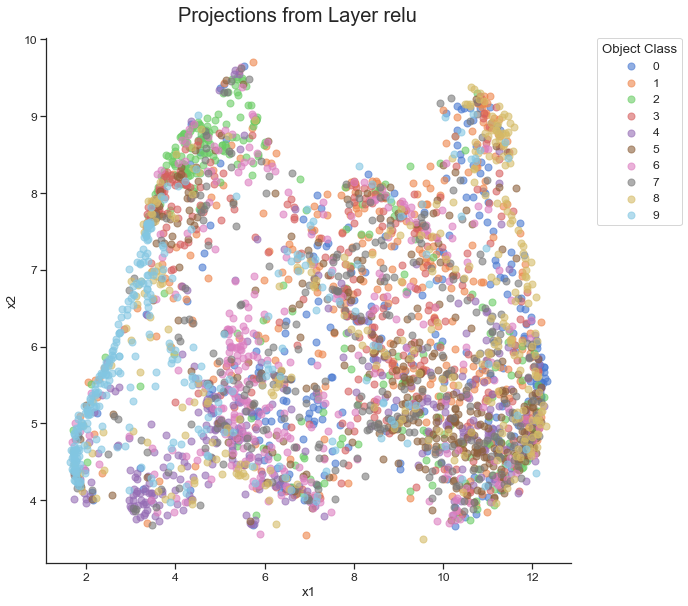

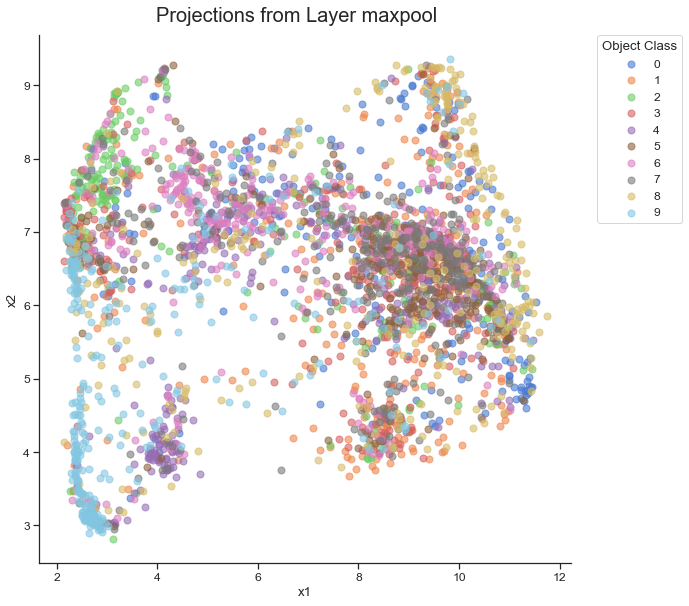

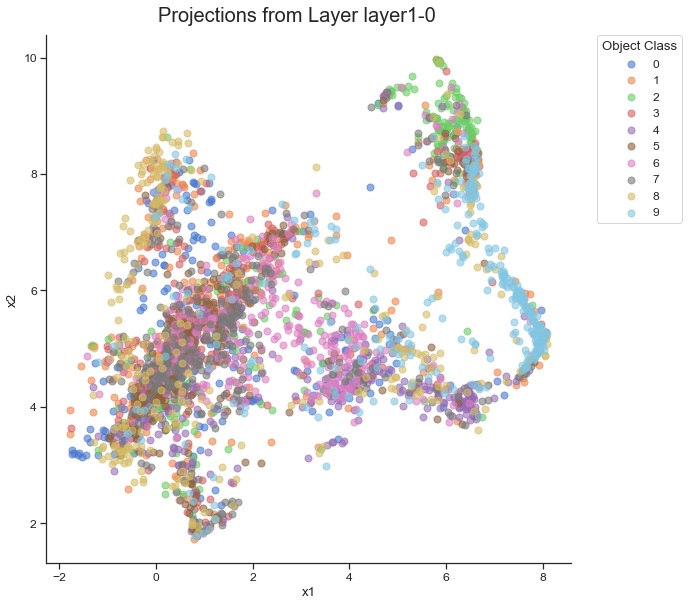

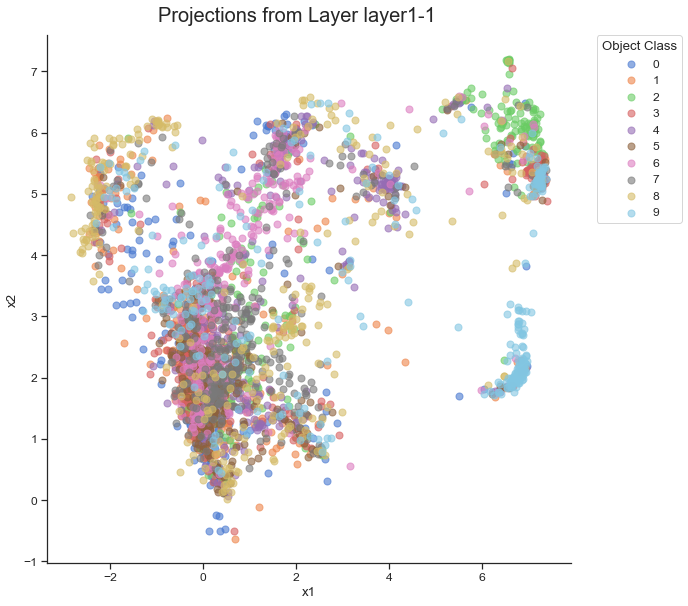

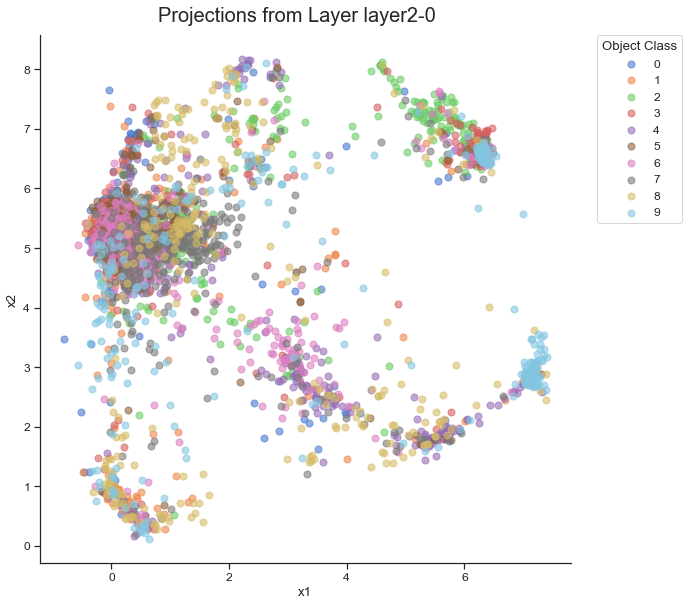

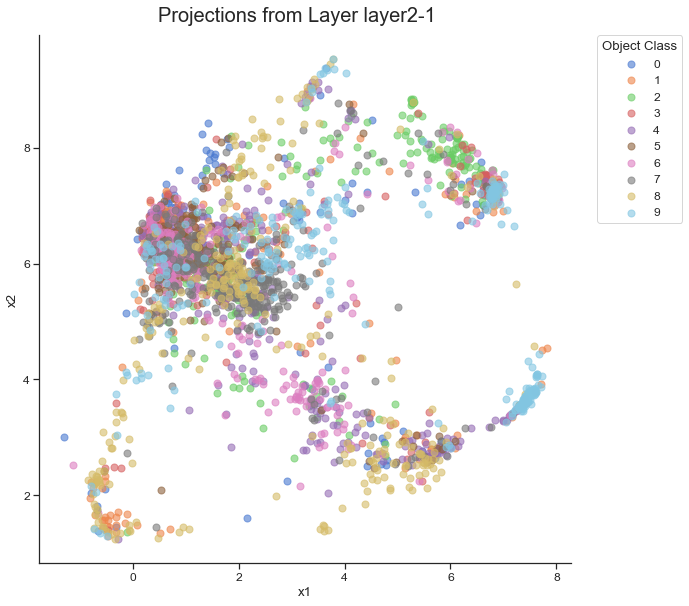

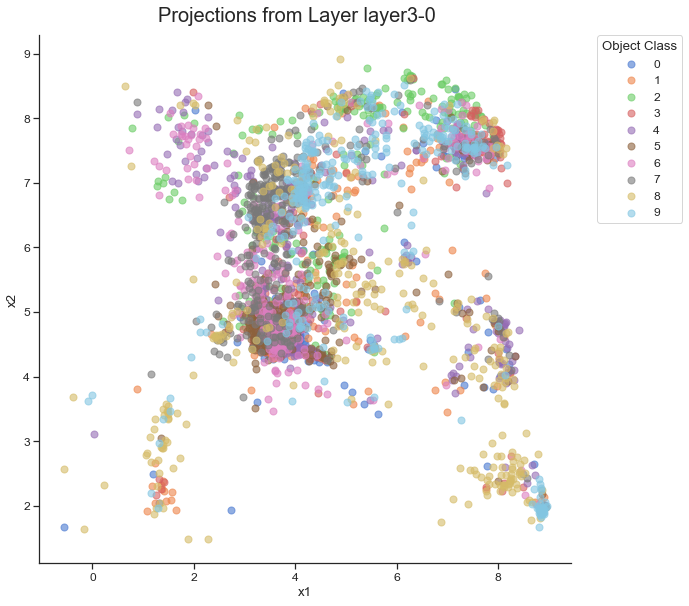

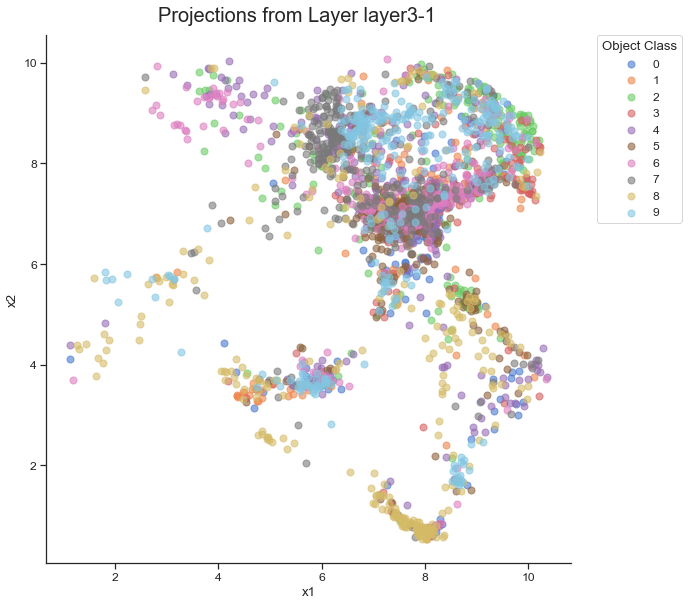

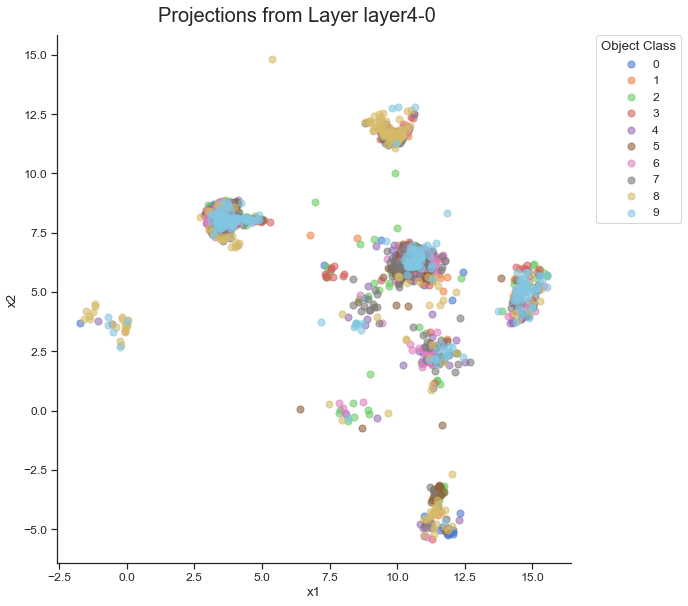

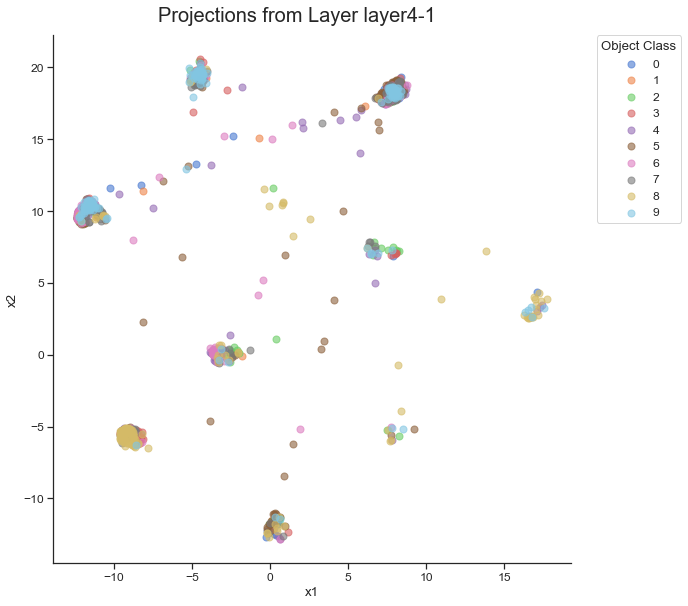

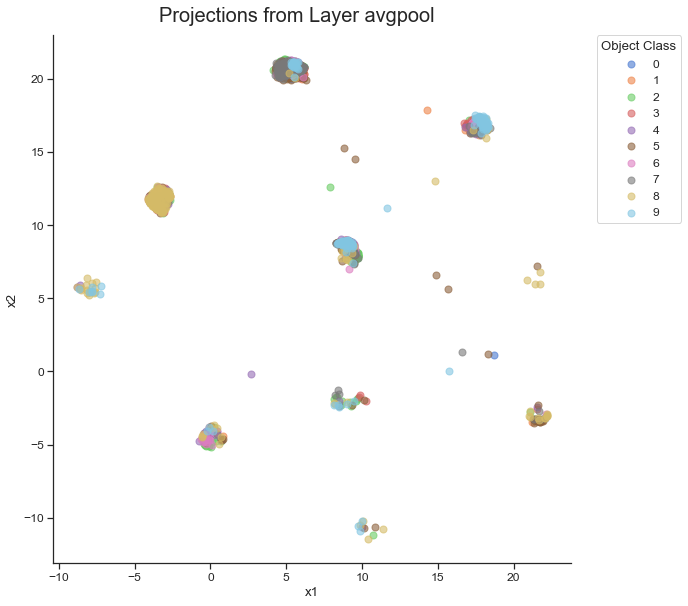

In [34]:
plot_projects(projections_test)

### Get Cluster Labels

In [35]:
def get_labels(projs, clusterer):
    labels = {}
    for layer_name in layers:
        labels[layer_name] = clusterer[layer_name].predict(projs[layer_name])
        
    return labels

In [36]:
start_cluster = time.time()

labels_test = get_labels(projections_test['projections'], loaded_clusters_and_stats['train_clusters']['clusterer'])

end_cluster = time.time()

In [37]:
for layer in layers:
    print('## layer {}'.format(layer))
    print('cluster labels:  {}'.format(labels_test[layer].shape))
    print()

## layer relu
cluster labels:  (3175,)

## layer maxpool
cluster labels:  (3175,)

## layer layer1-0
cluster labels:  (3175,)

## layer layer1-1
cluster labels:  (3175,)

## layer layer2-0
cluster labels:  (3175,)

## layer layer2-1
cluster labels:  (3175,)

## layer layer3-0
cluster labels:  (3175,)

## layer layer3-1
cluster labels:  (3175,)

## layer layer4-0
cluster labels:  (3175,)

## layer layer4-1
cluster labels:  (3175,)

## layer avgpool
cluster labels:  (3175,)



### Calculate Credibility

In [38]:
def calc_test_credibs(stats, layer_weights, class_label_calib_distro, projections, labels, t=0.01):
    num_samples = len(projections['targets'])
    credib_scores = np.array([0.0]*num_samples)
    
    # for each test sample calculate credib score
    for i in range(num_samples):
        class_intersect = []
        
        # for each layer get the classes of the cluster the test sample is in 
        # and finally get the class intersection over all layers
        for layer_name in layers:
            label = labels[layer_name][i]
            
            # only take the class if the percentage of that class in the training data is > t
            classes = [c for c in stats[layer_name][label].keys() if stats[layer_name][label][c] > t]
            
            # take the intesection of the classes
            if len(class_intersect) == 0:
                class_intersect += classes
            else:
                class_intersect = [c for c in class_intersect if c in classes]
        
        # if the class intersection is empty, the credib score is 0, otherwise calculate the credib score
        if len(class_intersect) == 0:
            credib_scores[i] = 0.0
        else:
            class_credibs = {}
            
            # for each remaining class calculate the credib score
            for c in class_intersect:
                class_credibs[c] = 0.0
                
                # for each layer calculate the credib score of that class
                for layer_name in layers:
                    label = labels[layer_name][i]
                    
                    # if the class is in the cluster of the calib data of that layer, take it, otherwise don't
                    # (if it is taken, it is multiplied with the layer weight to obtain a weighted average at the end)
                    if label in class_label_calib_distro[t][layer_name][c]:
                        class_credibs[c] += class_label_calib_distro[t][layer_name][c][label] * layer_weights[layer_name]
                    else:
                        class_credibs[c] = 0.0
                        break
                
            # use the max credib score among the remaining classes as the final credib score for that test sample
            credib_scores[i] = max(class_credibs.values())
    
    return credib_scores  

In [39]:
start_credib = time.time()

test_credibs = calc_test_credibs(
    loaded_clusters_and_stats['train_clusters']['stats'],  
    loaded_clusters_and_stats['layer_weights'],
    loaded_clusters_and_stats['calib_stats'],
    projections_test,
    labels_test,
    t
)

end_credib = time.time()

In [40]:
num_samples = len(projections_test['targets'])
total_credib = np.sum(np.array(test_credibs)) / num_samples
print(total_credib)

0.19291099576685022


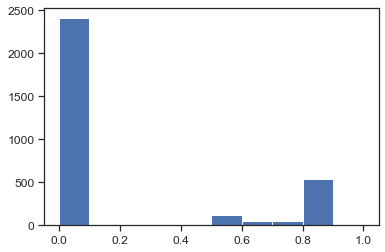

In [41]:
plt.hist(test_credibs, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

### Time Measurements

In [42]:
time_fetch_act = end_fetch_act - start_fetch_act
time_transf = end_transf - start_transf
time_proj = end_proj - start_proj
time_cluster = end_cluster - start_cluster
time_credib = end_credib - start_credib

time_total = time_fetch_act + time_transf + time_proj + time_cluster + time_credib

print(f"Fetching Activations:     {time_fetch_act}")
print(f"Transforming Activations: {time_transf}")
print(f"Creating Projections:     {time_proj}")
print(f"Getting Cluster Labels:   {time_cluster}")
print(f"Calculating Credibility:  {time_credib}")
print()
print(f"total: {time_total}")

Fetching Activations:     84.86615705490112
Transforming Activations: 34.58931303024292
Creating Projections:     74.66726517677307
Getting Cluster Labels:   0.008643150329589844
Calculating Credibility:  0.11397290229797363

total: 194.24535131454468
